In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/df_oversamling.csv')
data.head()

,userId,wine,rate
0,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Montepulciano 60,1
1,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1
2,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
3,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
4,5ccd8030-047b-432c-a630-d784ab415756,Bardolino Chiaretto,1


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class Knn (KNNBasic):
    def __init__(self, sim_options={}, bsl_options={}):
        KNNBasic.__init__(self, sim_options=sim_options, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)

    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNBasic.fit(self, trainset_fold)
            train_prediction = KNNBasic.test(self, trainset_fold.build_testset())
            prediction = KNNBasic.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNBasic.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## Knn SGD

* knn cosine, user based

In [4]:
knn = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn.create_reader(data)
predictions = knn.fit()
#acc
metrics = knn.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4072
RMSE: 0.6617
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4006
RMSE: 0.7391
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4027
RMSE: 0.7371
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3673
RMSE: 0.7304
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4166
RMSE: 0.6420
###############################################
The Results are: 

Average RMSE on Training Set: 0.39887695482739394
Average RMSE on Test Set: 0.7020424223760513
RMSE: 0.7205
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7204773728386509
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7205
MAE:  0.4058
MSE: 0.5191
Precision: 0.33
Recall: 0.27
the acc is 65.35


/tmp/ipykernel_17333/161991997.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [5]:
knn2 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn2.create_reader(data)
predictions = knn2.fit()
#acc
metrics = knn2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8627
RMSE: 0.9769
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8339
RMSE: 1.0109
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8683
RMSE: 0.9002
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8583
RMSE: 0.9120
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8547
RMSE: 0.9602
###############################################
The Results are: 

Average RMSE on Training Set: 0.8555962848620418
Average RMSE on Test Set: 0.9520552772403814
RMSE: 1.0753
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0753134429895028
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0753
MAE:  0.8144
MSE: 1.1563
Precision: 0.27
Recall: 0.27
the acc is 42.26


/tmp/ipykernel_17333/3130600781.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/3130600781.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [6]:
knn3 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn3.create_reader(data)
predictions = knn3.fit()
#acc
metrics = knn3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2302
RMSE: 0.6739
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2479
RMSE: 0.5812
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2128
RMSE: 0.6288
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2454
RMSE: 0.7206
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2409
RMSE: 0.6427
###############################################
The Results are: 

Average RMSE on Training Set: 0.23542327586617304
Average RMSE on Test Set: 0.6494409190575976
RMSE: 0.7502
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7501847801921632
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7502
MAE:  0.4047
MSE: 0.5628
Precision: 0.40
Recall: 0.33
the acc is 71.39


/tmp/ipykernel_17333/3369594395.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/3369594395.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared diference, item based

In [7]:
knn4 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn4.create_reader(data)
predictions = knn4.fit()
#acc
metrics = knn4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3118
RMSE: 0.6749
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3372
RMSE: 0.6806
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3351
RMSE: 0.7635
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3369
RMSE: 0.5704
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3267
RMSE: 0.6828
###############################################
The Results are: 

Average RMSE on Training Set: 0.32952695395123277
Average RMSE on Test Set: 0.6744519869466152
RMSE: 0.7508
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.750830939062338
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7508
MAE:  0.4644
MSE: 0.5637
Precision: 0.31
Recall: 0.27
the acc is 64.30


/tmp/ipykernel_17333/1900242280.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/1900242280.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, user based

In [8]:
knn5 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn5.create_reader(data)
predictions = knn5.fit()
#acc
metrics = knn5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1859
RMSE: 0.5726
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1953
RMSE: 0.6588
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2006
RMSE: 0.6659
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1458
RMSE: 0.7253
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1872
RMSE: 0.5904
###############################################
The Results are: 

Average RMSE on Training Set: 0.18298207277970854
Average RMSE on Test Set: 0.6426115668345032
RMSE: 0.6023
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6022787935837564
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6023
MAE:  0.3035
MSE: 0.3627
Precision: 0.33
Recall: 0.28
the acc is 73.75


/tmp/ipykernel_17333/3339916766.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/3339916766.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, item based

In [9]:
knn6 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn6.create_reader(data)
predictions = knn6.fit()
#acc
metrics = knn6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2218
RMSE: 0.7263
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1938
RMSE: 0.6123
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2130
RMSE: 0.5498
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2299
RMSE: 0.6796
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2017
RMSE: 0.6682
###############################################
The Results are: 

Average RMSE on Training Set: 0.2120253600706167
Average RMSE on Test Set: 0.6472422909136617
RMSE: 0.6378
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6378173409830289
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6378
MAE:  0.3202
MSE: 0.4068
Precision: 0.31
Recall: 0.27
the acc is 75.07


/tmp/ipykernel_17333/3614094042.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/3614094042.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [10]:
knn7 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn7.create_reader(data)
predictions = knn7.fit()
#acc
metrics = knn7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


/tmp/ipykernel_17333/3960392171.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/3960392171.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


RMSE: 0.1647
RMSE: 0.6254
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1822
RMSE: 0.6019
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1871
RMSE: 0.5314
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1572
RMSE: 0.6602
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1864
RMSE: 0.6099
###############################################
The Results are: 

Average RMSE on Training Set: 0.17551820536863882
Average RMSE on Test Set: 0.6057730912479614
RMSE: 0.6519
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6519338868602849
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.6519
MAE:  0.3489
MSE: 0.4250
Precision: 0.33
Recall: 0.21
the acc is 7

* knn (shrunk) pearson correlation coefficient, item based

In [11]:
knn8 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn8.create_reader(data)
predictions = knn8.fit()
#acc
metrics = knn8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3594
RMSE: 0.7448
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3719
RMSE: 0.6531
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3576
RMSE: 0.6316
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3641
RMSE: 0.6297
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3369
RMSE: 0.7035
###############################################
The Results are: 

Average RMSE on Training Set: 0.3579709104130412
Average RMSE on Test Set: 0.672534761454039
RMSE: 0.7234
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.723435241480826
Computing the pearson_baseline similarity matrix...

/tmp/ipykernel_17333/3933834523.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/3933834523.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## Knn Alternating Least Squares (ALS)

* knn cosine, user based

In [12]:
knn9 = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn9.create_reader(data)
predictions = knn9.fit()
#acc
metrics = knn9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3982
RMSE: 0.7265
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3967
RMSE: 0.6422
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3220
RMSE: 0.7900
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4112
RMSE: 0.6420
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3965
RMSE: 0.6496
###############################################
The Results are: 

Average RMSE on Training Set: 0.3849132934457834
Average RMSE on Test Set: 0.6900418767634526
RMSE: 0.6840
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6839907131730208
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6840
MAE:  0.3690
MSE: 0.4678
Precision: 0.36
Recall: 0.31
the acc is 68.77


/tmp/ipykernel_17333/3513140556.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/3513140556.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [13]:
knn10 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn10.create_reader(data)
predictions = knn10.fit()
#acc
metrics = knn10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8639
RMSE: 0.9603
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8674
RMSE: 1.0236
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8704
RMSE: 0.9322
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8531
RMSE: 0.9775
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8736
RMSE: 0.9177
###############################################
The Results are: 

Average RMSE on Training Set: 0.8656790363405342
Average RMSE on Test Set: 0.962278203175259
RMSE: 0.9614
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9613509069498244
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9614
MAE:  0.7007
MSE: 0.9242
Precision: 0.26
Recall: 0.27
the acc is 46.98


/tmp/ipykernel_17333/857205367.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/857205367.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [14]:
knn11 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn11.create_reader(data)
predictions = knn11.fit()
#acc
metrics = knn11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2310
RMSE: 0.5881
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2339
RMSE: 0.6275
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2222
RMSE: 0.5908
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2252
RMSE: 0.6818
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2267
RMSE: 0.6256
###############################################
The Results are: 

Average RMSE on Training Set: 0.22780494010323377
Average RMSE on Test Set: 0.6227699491935728
RMSE: 0.6560
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6559958805693228
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6560
MAE:  0.3636
MSE: 0.4303
Precision: 0.31
Recall: 0.25
the acc is 69.55


/tmp/ipykernel_17333/1804258722.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/1804258722.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, item based

In [15]:
knn12 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn12.create_reader(data)
predictions = knn12.fit()
#acc
metrics = knn12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3184
RMSE: 0.6705
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3113
RMSE: 0.6858
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3069
RMSE: 0.7131
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3052
RMSE: 0.7074
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3037
RMSE: 0.6994
###############################################
The Results are: 

Average RMSE on Training Set: 0.309083437343984
Average RMSE on Test Set: 0.6952455650704458
RMSE: 0.7790
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7790349031903868
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.7790
MAE:  0.4658
MSE: 0.6069
Precision: 0.31
Recall: 0.25
the acc is 66.14


/tmp/ipykernel_17333/262444695.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/262444695.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, user based

In [16]:
knn13 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn13.create_reader(data)
predictions = knn13.fit()
#acc
metrics = knn13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1664
RMSE: 0.7001
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2011
RMSE: 0.6652
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2034
RMSE: 0.6206
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2051
RMSE: 0.6321
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1714
RMSE: 0.5808
###############################################
The Results are: 

Average RMSE on Training Set: 0.18947822950001467
Average RMSE on Test Set: 0.6397573336058866
RMSE: 0.5713
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5713322495439467
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.5713
MAE:  0.2810
MSE: 0.3264
Precision: 0.33
Recall: 0.30
the acc is 76.38


/tmp/ipykernel_17333/1092855449.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/1092855449.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, item based

In [17]:
knn14 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn14.create_reader(data)
predictions = knn14.fit()
#acc
metrics = knn14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2174
RMSE: 0.6002
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1916
RMSE: 0.6005
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2183
RMSE: 0.6153
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1881
RMSE: 0.6014
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2119
RMSE: 0.5831
###############################################
The Results are: 

Average RMSE on Training Set: 0.2054407528970108
Average RMSE on Test Set: 0.6000807752504012
RMSE: 0.6270
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6269675294499024
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6270
MAE:  0.3332
MSE: 0.3931
Precision: 0.30
Recall: 0.27
the acc is 71.39


/tmp/ipykernel_17333/3580080987.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/3580080987.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [18]:
knn15 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn15.create_reader(data)
predictions = knn15.fit()
#acc
metrics = knn15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1714
RMSE: 0.6711
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1716
RMSE: 0.5611
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1587
RMSE: 0.5867
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1316
RMSE: 0.6785
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1677
RMSE: 0.6237
###############################################
The Results are: 

Average RMSE on Training Set: 0.16019435282419986
Average RMSE on Test Set: 0.6242183564653002
RMSE: 0.6069
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6069178384960907
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17333/3271800746.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/3271800746.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [19]:
knn16 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn16.create_reader(data)
predictions = knn16.fit()
#acc
metrics = knn16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3988
RMSE: 0.6592
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3503
RMSE: 0.6815
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3434
RMSE: 0.6762
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3517
RMSE: 0.6760
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3306
RMSE: 0.8389
###############################################
The Results are: 

Average RMSE on Training Set: 0.35494922311571775
Average RMSE on Test Set: 0.7063620017015669
RMSE: 0.7270
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7270223045607995
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17333/3154310150.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17333/3154310150.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
12,13,KnnBasic,pearson corr coeff,ALS,True,0.571332,0.281010,0.326421,0.330833,0.299662,76.377953
4,5,KnnBasic,pearson corr coeff,SGD,True,0.602279,0.303473,0.362740,0.329670,0.276823,73.753281
14,15,KnnBasic,(shrunk) pearson corr coeff,ALS,True,0.606918,0.328558,0.368349,0.302083,0.249594,71.391076
13,14,KnnBasic,pearson corr coeff,ALS,False,0.626968,0.333205,0.393088,0.302579,0.268434,71.391076
5,6,KnnBasic,pearson corr coeff,SGD,False,0.637817,0.320231,0.406811,0.311080,0.268905,75.065617
6,7,KnnBasic,(shrunk) pearson corr coeff,SGD,True,0.651934,0.348921,0.425018,0.327381,0.208378,70.603675
10,11,KnnBasic,MSD,ALS,True,0.655996,0.363569,0.430331,0.310345,0.253534,69.553806
8,9,KnnBasic,Cosine,ALS,True,0.683991,0.368951,0.467843,0.358232,0.306102,68.766404
0,1,KnnBasic,Cosine,SGD,True,0.720477,0.405813,0.519088,0.329757,0.268450,65.354331
7,8,KnnBasic,(shrunk) pearson corr coeff,SGD,False,0.723435,0.441450,0.523359,0.319766,0.266232,62.467192


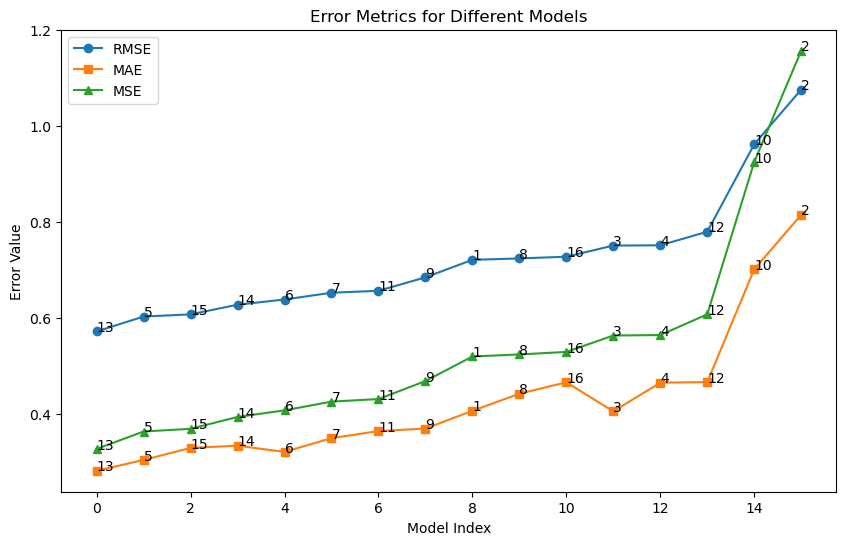

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

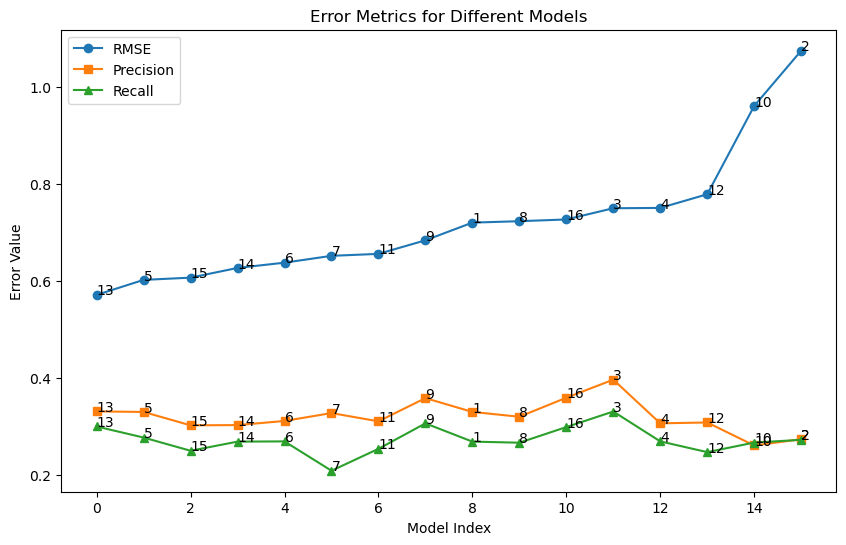

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

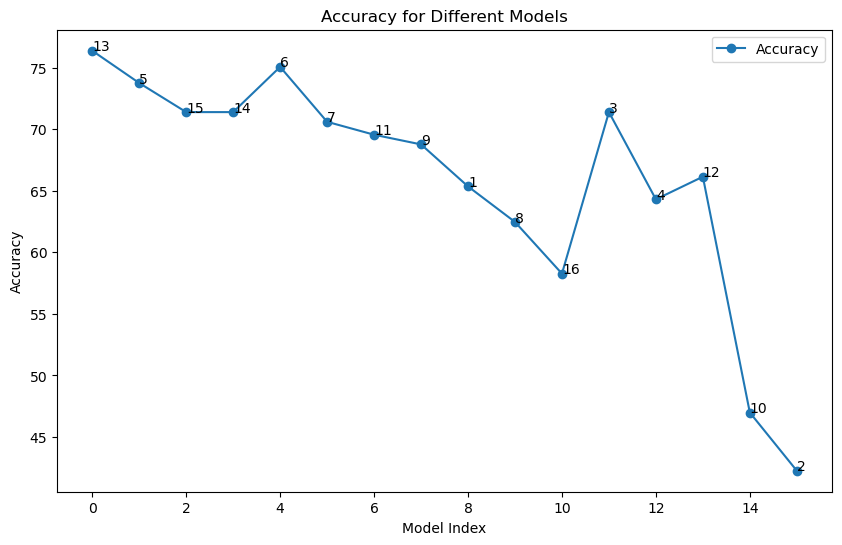

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
knn.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 15 with sim 0.991240707161930
user 130 with sim 0.000000000000000
And the baseline estimate is: 3.009039207956347

#####

Note: If the baseline is 3.0 then the value is a default value, Otherwise not


In [25]:
df_pred = knn.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1.0,1.000000,"{'actual_k': 16, 'was_impossible': False}",14,14,0.000000
1,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Groot Constantia,2.0,1.413302,"{'actual_k': 36, 'was_impossible': False}",72,3,0.586698
2,5ccd8030-047b-432c-a630-d784ab415756,Punt dal crèt,3.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",126,1,0.046721
3,877019f9-3c77-491d-912e-58b2404aed47,Chianti,1.0,1.200000,"{'actual_k': 15, 'was_impossible': False}",17,24,0.200000
4,91cf68cc-9436-43e1-871d-33beef4d2337,Alsace Josmeyer Gewurztraminer Biodynamic,4.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",56,0,1.046721
5,bc79b0e3-064d-4240-86de-e86499f577e8,Terroir de Granit Saint Joseph,5.0,4.950014,"{'actual_k': 39, 'was_impossible': False}",98,4,0.049986
6,5ccd8030-047b-432c-a630-d784ab415756,La Moneta Gavi,2.0,1.686847,"{'actual_k': 40, 'was_impossible': False}",126,5,0.313153
7,3d88fe74-6881-42bd-bb97-d67f2db649d7,Dark Horse Shiraz,2.0,2.000000,"{'actual_k': 5, 'was_impossible': False}",4,3,0.000000
8,4ed273f7-1816-4f36-88c7-789125f011c7,Moscato d'Asti,1.0,1.222222,"{'actual_k': 18, 'was_impossible': False}",15,15,0.222222
9,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Fumin la griffe,3.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",99,1,0.046721


* best predictions

In [26]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
0,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1.0,1.0,"{'actual_k': 16, 'was_impossible': False}",14,14,0.0
170,3dd9219a-c64e-4c5a-a61b-aad6a417a69a,Brachetto Piemonte,3.0,3.0,"{'actual_k': 1, 'was_impossible': False}",2,6,0.0
171,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 11,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",98,18,0.0
180,3d88fe74-6881-42bd-bb97-d67f2db649d7,Dark Horse Shiraz,2.0,2.0,"{'actual_k': 5, 'was_impossible': False}",4,3,0.0
191,bc79b0e3-064d-4240-86de-e86499f577e8,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",98,18,0.0
192,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Reserva Rioja,5.0,5.0,"{'actual_k': 32, 'was_impossible': False}",55,2,0.0
193,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Casillero del diabolo merlot Chile,5.0,5.0,"{'actual_k': 38, 'was_impossible': False}",55,1,0.0
201,7ed7fb0c-884d-46bf-a14a-205474a0949d,Bardolino,2.0,2.0,"{'actual_k': 6, 'was_impossible': False}",5,5,0.0
202,9a3cc655-c88e-4c1b-95e2-add7579ff4c2,Malvasia legno,3.0,3.0,"{'actual_k': 4, 'was_impossible': False}",8,1,0.0
205,8764df8a-0919-433c-beab-053a9c12f402,Nero d'Avola Sicilia,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,1,0.0


* worst predictions

In [27]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
235,25a04c51-5638-42f0-b2e7-ce49b1c280fc,Franciacorta Milledì Brut,5.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",7,0,2.046721
194,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Grande reserve,5.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",55,2,2.046721
284,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Diablo black cabernet sauvignin,5.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",55,1,2.046721
212,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Theo,5.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",61,3,2.046721
290,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Beaune 1er cru 'Clos les Aigrots',5.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",72,1,2.046721
46,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 5,5.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",98,1,2.046721
304,2ae69fac-d491-412f-8164-ccaf59a230c2,Perbacco Nebbiolo,5.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",9,3,2.046721
50,b0fbc6bd-4b1e-48cd-92f3-f49b7a505941,Taurasi Vigna Cinque Querce,5.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",4,1,2.046721
321,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Sori Tildin,5.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",128,1,2.046721
204,23b6603a-928c-4e54-9c34-bdf3dcb45435,Gewurztraminer,5.0,2.953279,"{'was_impossible': True, 'reason': 'User and/o...",2,1,2.046721
